In [1]:
struct Item
    value::Int64
    weight::Int64
end

struct Individual
    bits::Vector{Int}
end

# Instance

In [2]:
using Random

Random.seed!(0)
function generate_instance(n::Int)
    return [Item(rand(1:100), rand(1:100)) for _ in 1:n]
end

n = 20
items = generate_instance(n) # Item 20개 생성
capacity = 200 # 배낭 최대 무게

200

# Exact Algorithm

In [3]:
using Knapsacks

function kp_expandingcore(values::Vector{Int}, weights::Vector{Int}, capacity::Int)
    data = Knapsack(capacity, weights, values)

    opt, sol = solveKnapsack(data, :ExpandingCore)
    
    return opt, sol
end

kp_expandingcore (generic function with 1 method)

In [4]:
# 값 및 무게 벡터 생성
values = [item.value for item in items]
weights = [item.weight for item in items]

# Knapsacks 패키지로 문제 해결
opt, sol = kp_expandingcore(values, weights, capacity)

println("Objective value: ", opt)
println("Solution: ", sol)

Objective value: 643
Solution: [1, 2, 3, 5, 7, 9, 12, 15, 16, 19]


# Genetic Algorithm

In [5]:
function is_valid(individual::Individual, items::Vector{Item}, capacity::Int64)
    total_weight = sum(bit * item.weight for (item, bit) in zip(items, individual.bits))
    return total_weight <= capacity
end

is_valid (generic function with 1 method)

In [6]:
function generate_initial_population(items::Vector{Item}, capacity::Int64, count::Int)
    population = Set{Individual}()

    while length(population) != count
        bits = [rand(Bool) for _ in 1:length(items)]
        if is_valid(Individual(bits), items, capacity)
            push!(population, Individual(bits))
        end
    end
    
    return collect(population)
end

generate_initial_population (generic function with 1 method)

In [7]:
function fitness(individual::Individual, items::Vector{Item}, capacity::Int64)
    total_value = sum(bit * item.value for (item, bit) in zip(items, individual.bits))
    total_weight = sum(bit * item.weight for (item, bit) in zip(items, individual.bits))

    @assert total_weight <= capacity # 배낭 무게 제한 확인
    return total_value
end

fitness (generic function with 1 method)

In [8]:
function selection(population::Vector{Individual}, items::Vector{Item}, capacity::Int64, TOURNAMENT_SIZE::Int64)
    parents = Vector{Individual}()
    while length(parents) < 2
        shuffle!(population)

        tournament = [population[i] for i in 1:TOURNAMENT_SIZE]
        best_individual = tournament[argmax([fitness(ind, items, capacity) for ind in tournament])]
        push!(parents, best_individual)
    end
    
    #println("Selection")
    return parents
end

function crossover(parents::Vector{Individual}, items::Vector{Item}, capacity::Int64)
    N = length(items)
    valid_children = Vector{Individual}()

    while length(valid_children) < 2
        # Randomly select crossover point
        crossover_point = rand(1:N-1)

        # Create children by swapping bits between parents at crossover point
        child1_bits = vcat(parents[1].bits[1:crossover_point], parents[2].bits[crossover_point+1:end])
        child2_bits = vcat(parents[2].bits[1:crossover_point], parents[1].bits[crossover_point+1:end])

        child1 = Individual(child1_bits)
        child2 = Individual(child2_bits)

        if is_valid(child1, items, capacity)
            push!(valid_children, child1)
        end
        
        if is_valid(child2, items, capacity)
            push!(valid_children, child2)
        end
    end

    #println("Crossover")
    return valid_children
end

function mutate!(individuals::Vector{Individual}, items::Vector{Item}, capacity::Int64, MUTATION_RATE::Float64)
    for individual in individuals
        while !is_valid(individual, items, capacity)
            for i in 1:length(individual.bits)
                if rand() < MUTATION_RATE
                    individual.bits[i] = 1 - individual.bits[i]
                end
            end
        end
    end

    #println("Mutation")
    return individuals
end


mutate! (generic function with 1 method)

In [9]:
function next_generation(population::Vector{Individual}, items::Vector{Item}, capacity::Int64, REPRODUCTION_RATE::Float64, CROSSOVER_RATE::Float64, MUTATION_RATE::Float64)
    next_gen = Vector{Individual}()

    while length(next_gen) < length(population)
        children = Vector{Individual}()

        TOURNAMENT_SIZE = 5
        parents = selection(population, items, capacity, TOURNAMENT_SIZE)

        if rand() < REPRODUCTION_RATE
            children = parents
        else
            if rand() < CROSSOVER_RATE
                children = crossover(parents, items, capacity)
            end

            if rand() < MUTATION_RATE
                mutate!(children, items, capacity, MUTATION_RATE)
            end
        end

        append!(next_gen, children)
    end
    
    return next_gen[1:length(population)]
end

next_generation (generic function with 1 method)

In [10]:
function average_fitness(population::Vector{Individual}, items::Vector{Item}, capacity::Int64)
    total_fitness = sum(fitness(ind, items, capacity) for ind in population)
    return total_fitness / length(population)
end

average_fitness (generic function with 1 method)

In [11]:
using Plots

function plot_generation(avg_fitness::Vector{Float64})
    plot(avg_fitness, label="Average Fitness", xlabel="Generation", ylabel="Fitness")
end


plot_generation (generic function with 1 method)

In [12]:
using Plots 
function kp_genetic(items::Vector{Item}, capacity::Int64, SIZE_OF_POPULATION::Int64, REPRODUCTION_RATE::Float64, CROSSOVER_RATE::Float64, MUTATION_RATE::Float64)
    population = generate_initial_population(items, capacity, SIZE_OF_POPULATION)

    avg_fitnesses = Float64[]

    for i in 1:50 # 50세대까지 진행
        current_avg_fitness = average_fitness(population, items, capacity)
        push!(avg_fitnesses, current_avg_fitness)
        #println("Generation $i - Average Fitness $current_avg_fitness")
        population = next_generation(population, items, capacity, REPRODUCTION_RATE, CROSSOVER_RATE, MUTATION_RATE)
    end
    
    population = sort(population, by=i -> fitness(i, items, capacity), rev=true)
    best_individual = population[1]
    sol = [i for i in 1:length(best_individual.bits) if best_individual.bits[i] == 1]
    opt = fitness(best_individual, items, capacity)
    return opt, sol, avg_fitnesses
end

kp_genetic (generic function with 1 method)

Best Objective Value: 590
Best Solution: [1, 2, 3, 5, 9, 12, 13, 15, 16, 18]


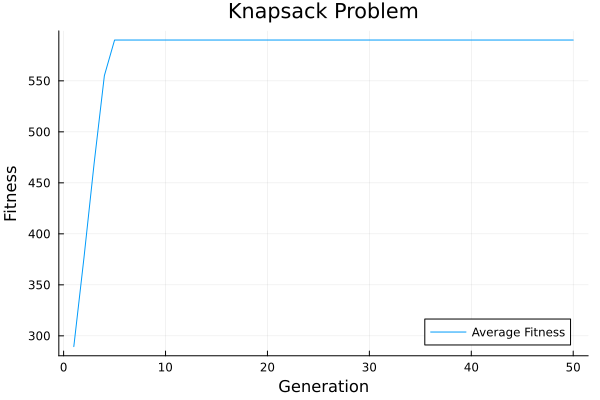

In [13]:
# Parameters
SIZE_OF_POPULATION = 20
REPRODUCTION_RATE = 0.2
CROSSOVER_RATE = 0.8 
MUTATION_RATE = 0.01

# Solve
opt2, sol2, avg_fitnesses = kp_genetic(items, capacity, SIZE_OF_POPULATION, REPRODUCTION_RATE, CROSSOVER_RATE, MUTATION_RATE)
println("Best Objective Value: ", opt2)
println("Best Solution: ", sol2)
display(plot(avg_fitnesses, label="Average Fitness", xlabel="Generation", ylabel="Fitness", title = "Knapsack Problem"))

# Experiment

In [14]:
# kp_expandingcore 과 GA 알고리즘 비교
function experiment(n, SIZE_OF_POPULATION = 20, REPRODUCTION_RATE = 0.2, CROSSOVER_RATE = 0.8, MUTATION_RATE = 0.01)
    Random.seed!(0)
    items = generate_instance(n) 
    values = [item.value for item in items]
    weights = [item.weight for item in items]
    capacity = 200 
    println("-------- Knapsack Problem with $n items --------")
    println("Capacity: ", capacity)
    println("Values of items: ", values)
    println("Weights of items: ", weights)

    # ExpandingCore Algorithm
    println("-------- Exact Algorithm --------")
    opt, sol = kp_expandingcore(values, weights, capacity)
    println("Exact - Optimal Value: ", opt)
    println("Exact - Optimal Solution : ", sol)

    # GA Algorithm
    println("-------- Heuristic Algorithm --------")
    opt_ga, sol_ga, fitnesses = kp_genetic(items, capacity, SIZE_OF_POPULATION, REPRODUCTION_RATE, CROSSOVER_RATE, MUTATION_RATE)
    println("Metaheuristic - Objective Value: ", opt_ga)
    println("Metaheuristic - Feasible Solution: ", sol_ga)

    gap = (opt - opt_ga) / opt * 100

    return gap, fitnesses
end

experiment (generic function with 5 methods)

In [15]:
n = 10
gap, _ = experiment(n)
println("--------------------------------------------")
println("Optimality Gap of Genetic Algorithm: ", round(gap, digits = 4), "%")

-------- Knapsack Problem with 10 items --------
Capacity: 200
Values of items: [41, 87, 67, 11, 29, 54, 26, 43, 75, 58]
Weights of items: [7, 9, 12, 71, 3, 90, 34, 91, 16, 46]
-------- Exact Algorithm --------
Exact - Optimal Value: 411
Exact - Optimal Solution : [1, 2, 3, 5, 6, 9, 10]
-------- Heuristic Algorithm --------
Metaheuristic - Objective Value: 411
Metaheuristic - Feasible Solution: [1, 2, 3, 5, 6, 9, 10]
--------------------------------------------
Optimality Gap of Genetic Algorithm: 0.0%


In [16]:
n = 20
gap, _ = experiment(n)
println("--------------------------------------------")
println("Optimality Gap of Genetic Algorithm: ", round(gap, digits = 4), "%")

-------- Knapsack Problem with 20 items --------
Capacity: 200
Values of items: [41, 87, 67, 11, 29, 54, 26, 43, 75, 58, 2, 64, 43, 45, 87, 77, 9, 20, 90, 71]
Weights of items: [7, 9, 12, 71, 3, 90, 34, 91, 16, 46, 50, 9, 58, 63, 52, 14, 36, 12, 43, 89]
-------- Exact Algorithm --------
Exact - Optimal Value: 643
Exact - Optimal Solution : [1, 2, 3, 5, 7, 9, 12, 15, 16, 19]
-------- Heuristic Algorithm --------
Metaheuristic - Objective Value: 468
Metaheuristic - Feasible Solution: [1, 2, 3, 6, 10, 12, 16, 18]
--------------------------------------------
Optimality Gap of Genetic Algorithm: 27.2162%


In [17]:
n = 30
gap, _ = experiment(n)
println("--------------------------------------------")
println("Optimality Gap of Genetic Algorithm: ", round(gap, digits = 4), "%")

-------- Knapsack Problem with 30 items --------
Capacity: 200
Values of items: [41, 87, 67, 11, 29, 54, 26, 43, 75, 58, 2, 64, 43, 45, 87, 77, 9, 20, 90, 71, 94, 99, 7, 5, 50, 17, 64, 42, 88, 1]
Weights of items: [7, 9, 12, 71, 3, 90, 34, 91, 16, 46, 50, 9, 58, 63, 52, 14, 36, 12, 43, 89, 84, 40, 64, 33, 86, 69, 22, 71, 76, 61]
-------- Exact Algorithm --------
Exact - Optimal Value: 713
Exact - Optimal Solution : [1, 2, 3, 5, 9, 12, 16, 18, 19, 22, 27]
-------- Heuristic Algorithm --------
Metaheuristic - Objective Value: 566
Metaheuristic - Feasible Solution: [2, 3, 5, 9, 10, 15, 22, 27]
--------------------------------------------
Optimality Gap of Genetic Algorithm: 20.6171%


# Parameters

-------- Knapsack Problem with 20 items --------
Capacity: 200
Values of items: [41, 87, 67, 11, 29, 54, 26, 43, 75, 58, 2, 64, 43, 45, 87, 77, 9, 20, 90, 71]
Weights of items: [7, 9, 12, 71, 3, 90, 34, 91, 16, 46, 50, 9, 58, 63, 52, 14, 36, 12, 43, 89]
-------- Exact Algorithm --------
Exact - Optimal Value: 643
Exact - Optimal Solution : [1, 2, 3, 5, 7, 9, 12, 15, 16, 19]
-------- Heuristic Algorithm --------
Metaheuristic - Objective Value: 494
Metaheuristic - Feasible Solution: [1, 2, 9, 12, 13, 15, 16, 18]
--------------------------------------------
Optimality Gap of Genetic Algorithm: 23.1726%


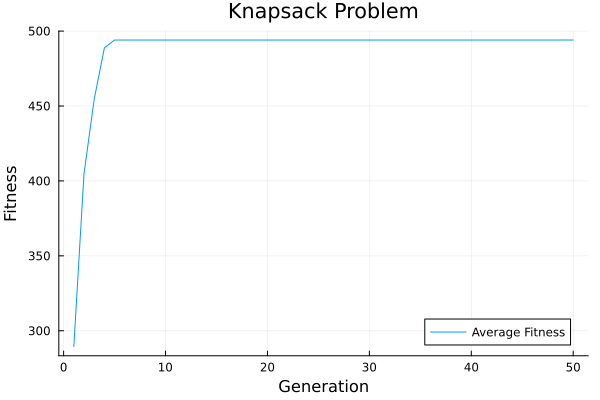

In [18]:
n = 20
###### Change Parameters ######
ENTER_SIZE_OF_POPULATION = 20
ENTER_CROSSOVER_RATE = 0.8
ENTER_MUTATION_RATE = 0.01
###############################
gap, fitnesses = experiment(n, ENTER_SIZE_OF_POPULATION, 0.2, ENTER_CROSSOVER_RATE, ENTER_MUTATION_RATE)
println("--------------------------------------------")
println("Optimality Gap of Genetic Algorithm: ", round(gap, digits = 4), "%")
display(plot(fitnesses, label="Average Fitness", xlabel="Generation", ylabel="Fitness", title = "Knapsack Problem"))